## Load API keys needed for Elsevier and Dropbox

Set the API keys in [api_keys.ipynb](api_keys.ipynb).

In [ ]:
%run api_keys.ipynb

### Connect to Scopus

In [ ]:
%run scopus.ipynb

## Obtain records

In [ ]:
scopus_query = "tourism+AND+innovation"

In [ ]:
data = scopus_retrive(scopus_query, save_to_file='tmp_all.csv')
print('Documents loaded: {}'.format(len(data)))

In [1]:
import pandas as pd
data = pd.read_csv('../Stakeholders/Stakeholders-clean.csv')

In [ ]:
data

## Preprocess

In [50]:
%run preprocessing.ipynb

[nltk_data] Downloading package stopwords to /Users/ajda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ajda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [51]:
ignore_words = [
    "finding", "research", "purpose", "study", "methodology", "result", 
    "analysis", "method", "paper", "literature", "tourism", "also", "within", 
    "whereas", "would", "fig", "may", "however", "could", "might"
]

In [52]:
keyword = "tourist"

In [53]:
documents_tokens, data_preprocessed = preprocess(data, to_ignore=ignore_words, keyword=keyword, save_to_file='stakeholders_preprocessed_pattern2.csv')
print('Documents kept after preprocessing: {}'.format(len(documents_tokens)))

Documents kept after preprocessing: 405


## Basic statistics

In [59]:
bigram_measures = BigramAssocMeasures()
flat_tokens = [t for doc in documents_tokens for t in doc]
finder = BigramCollocationFinder.from_words(flat_tokens)
finder.apply_freq_filter(5)
for (i, j), score in finder.score_ngrams(bigram_measures.pmi):
    if score > 5:
        print(i, j, ': ', score)

interlock directorship :  12.28139881653756
copper canyon :  12.018364410703768
sea sand :  10.57357956803087
scuba dive :  10.355399397981337
carry capacity :  9.821967197900264
policy maker :  9.785987900794696
play role :  8.603326911424924
data collection :  8.374508220929043
population size :  8.363860976729532
attitude toward :  8.201671624066828
firm locate :  7.881468209648924
toward ecotourism :  7.796687789451905
dark site :  7.773604176338862
government agency :  7.7578368604805465
tour operator :  7.594675977150976
theme park :  7.415150205426389
tour guide :  7.326009703237853
loyalty intention :  7.284818337078704
set variable :  7.271414727964938
climate change :  7.169393791024428
message take :  7.107027910064055
actor involve :  6.774661483121907
relation network :  6.706489980480326
quality life :  6.684794909381008
intention revisit :  6.440096562556617
management scenario :  6.437518018454842
production consumption :  6.251651473143509
value chain :  6.231187370583

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

### Word Frequencies

Find most frequent words in the corpus.

In [42]:
fdist = word_frequencies(documents_tokens)

Change `show_top_n` to adjust the number of words to display.

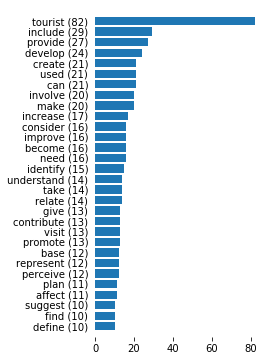

In [43]:
show_top_n = 30

# calc
mc = fdist.most_common(show_top_n)

# plot
mc = mc[::-1] ; ws, fs = zip(*mc) ; ws = ['{} ({})'.format(w, f) for w, f in mc]
plt.figure(figsize=(3, 6*show_top_n/30))
plt.box(False); plt.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)
plt.barh(range(len(ws)), fs) ; plt.yticks(range(len(ws)), ws); plt.ylim(-1, len(ws));
plt.savefig('freq-dist-stakeholders')

### Context of words

Find common contexts (co-occurring words) where the words from the list appear.

In [ ]:
word_list = ['stakeholder', 'tourist']

context = word_contexts(documents_tokens, word_list, num=30)

## Topic discovery

In [ ]:
%run "Topic Modeling/pyldavis.ipynb"

### Show topics and most frequently used words in each topic
Set `num_topics` to the expected number of topics in the corpus.

Set `num_words` to control the number of ***most frequent*** words listed for each topic.

In [ ]:
num_topics = 7
num_words = 10

corpus, dictionary, ldamodel = pyldavis_prep(documents_tokens, num_topics=num_topics, num_words=num_words)

### Interactive visualization of topics

The visualization shows topics as circles in a 2D plot. This is an approximation of topic similarity. The more similar two topics are, the closer they will be in the plot. The size of the circle corresponds to the presence of the topic in the corpus.

The visualization also shows the top 30 ***most relevant*** terms (words) for each topic. If a word is frequent in a topic, but also in the entire corpus, it will get a lower relevance score than a word that is frequent in a topic alone. 

***Relevance*** of a word in a topic is a weighted measure of the word probability within the topic and the word lift (the ratio of the word probability within the topic to its probability in the entire corpus). 

***Saliency*** refers to the importance of each word for a topic.


How to interact with the visualization:
1. Select a topic by clicking on a circle in the plot or by selecting a topic number in the control area at the top.

2. On the right, you see the most relevant terms for the selected topic. Adjust the relevance slider. For `lambda = 0` it is equal to the lift of the word, for `lambda = 1` it is equal to probability of the word within the topic.

3. If you click on a word in the histogram on the right, topic circles will resize according to the ***saliency*** of the term in the topic.

In [ ]:
pyldavis_vis(corpus, dictionary, ldamodel, save_to_html='stakeholders.html')

## Cluster documents and topics

Add topic vectors and generate a clustering of documents.

In [ ]:
%run "Topic Modeling/visualization.ipynb"

In [ ]:
topic_vectors = add_topics_vector(corpus, ldamodel)
data_preprocessed_vectors = pd.concat([data_preprocessed, topic_vectors], axis=1)
data_preprocessed_vectors.to_csv('tmp_preprocessed_vectors.csv', index=True)

Visualize with heatmaps.

In [ ]:
hm, cm = visualize(topic_vectors)

Visualize by time.

In [ ]:
datetime_data = get_datetime(topic_vectors, data)
hm_t = heat_map_time('2000-01-01', '2010-12-31', datetime_data)

In [ ]:
dominant_topic = get_dominant_topic(ldamodel, corpus, data)
dominant_topic

In [ ]:
new = pd.concat([data_preprocessed_vectors, dominant_topic], axis=1)
new

In [ ]:
new = new.drop(['CitedBy', 'URL', 'Document_No', 'Text'], axis=1)

In [ ]:
new.to_csv('technology-topics.csv')

In [ ]:
representative_docs = get_representative_doc(dominant_topic)
representative_docs

In [ ]:
representative_docs.to_csv('representative-docs-LDA7.csv')

In [ ]:
topic_distribution = get_topic_distribution(dominant_topic, representative_docs)
topic_distribution

In [ ]:
topic_distribution.to_csv('topic-distribution.csv')